In [1]:
import gc
import warnings
import numpy as np
import pandas as pd

#settings
warnings.filterwarnings('ignore')
np.random.seed(2018)


train_df = pd.read_csv('input/train.csv')
test_df = pd.read_csv('input/test.csv')
historical_trans_df = pd.read_csv('input/historical_transactions.csv')
new_merchant_trans_df = pd.read_csv('input/new_merchant_transactions.csv')
# TODO: consider missing merchants.csv

In [2]:
from src.util import preprocess_hist

for df in [historical_trans_df, new_merchant_trans_df]:
    preprocess_hist(df)

In [3]:
from src.util import aggregate_transactions
    
historical_trans_group_df = aggregate_transactions(historical_trans_df, "hist")
new_merchant_trans_group_df = aggregate_transactions(new_merchant_trans_df, "hist_new")

In [4]:
train_df = train_df.merge(historical_trans_group_df, on='card_id', how='left')
test_df = test_df.merge(historical_trans_group_df, on='card_id', how='left')

train_df = train_df.merge(new_merchant_trans_group_df, on='card_id', how='left')
test_df = test_df.merge(new_merchant_trans_group_df, on='card_id', how='left')

del historical_trans_group_df, new_merchant_trans_group_df
gc.collect()

49

In [5]:
train_df['outliers'] = 0
train_df.loc[train_df['target'] < -30, 'outliers'] = 1
train_df['outliers'].value_counts()

0    199710
1      2207
Name: outliers, dtype: int64

In [6]:
from src.util import extract_features

for df in [train_df, test_df]:
    extract_features(df)

In [7]:
from src.model import train_and_predict

features = [c for c in train_df.columns if c not in ['card_id', 'first_active_month','target','outliers']]
categorical_feats = ["feature_1", "feature_2", "feature_3"]

reg_param = {'num_leaves': 31,
         'min_data_in_leaf': 200, 
         'objective':'regression',
         'learning_rate': 0.015,
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "metric": 'rmse',
         "nthread": 40,
         "random_state": 0}

oof_reg, test_reg, feature_importance_reg = train_and_predict(train_df, test_df, "target", reg_param,
                                                              features, categorical_feats, 4)

fold 0
Training until validation scores don't improve for 100 rounds.
[200]	training's rmse: 1.55902	valid_1's rmse: 1.5736
[400]	training's rmse: 1.53616	valid_1's rmse: 1.5619
[600]	training's rmse: 1.5227	valid_1's rmse: 1.55893
[800]	training's rmse: 1.51174	valid_1's rmse: 1.55772
[1000]	training's rmse: 1.50176	valid_1's rmse: 1.55706
[1200]	training's rmse: 1.49241	valid_1's rmse: 1.55667
[1400]	training's rmse: 1.48327	valid_1's rmse: 1.55648
[1600]	training's rmse: 1.47471	valid_1's rmse: 1.55644
Early stopping, best iteration is:
[1589]	training's rmse: 1.47517	valid_1's rmse: 1.55639
fold 1
Training until validation scores don't improve for 100 rounds.
[200]	training's rmse: 1.55767	valid_1's rmse: 1.57753
[400]	training's rmse: 1.5347	valid_1's rmse: 1.56576
[600]	training's rmse: 1.52111	valid_1's rmse: 1.56284
[800]	training's rmse: 1.51024	valid_1's rmse: 1.56146
[1000]	training's rmse: 1.50027	valid_1's rmse: 1.56084
[1200]	training's rmse: 1.4909	valid_1's rmse: 1.5605

In [8]:
bin_param = {'num_leaves': 31,
         'min_data_in_leaf': 200, 
         'objective':'binary',
         'learning_rate': 0.015,
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "metric": 'auc',
         "nthread": 40,
         "random_state": 0}

oof_bin, test_bin, feature_importance_bin = train_and_predict(train_df, test_df, "outliers", bin_param, 
                                                              features, categorical_feats, 4)

fold 0
Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.958486	valid_1's auc: 0.902483
Early stopping, best iteration is:
[229]	training's auc: 0.96427	valid_1's auc: 0.902842
fold 1
Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.958954	valid_1's auc: 0.90672
[400]	training's auc: 0.982441	valid_1's auc: 0.908437
Early stopping, best iteration is:
[371]	training's auc: 0.980268	valid_1's auc: 0.908689
fold 2
Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.95723	valid_1's auc: 0.906202
Early stopping, best iteration is:
[203]	training's auc: 0.957763	valid_1's auc: 0.906309
fold 3
Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.958391	valid_1's auc: 0.897312
Early stopping, best iteration is:
[271]	training's auc: 0.970794	valid_1's auc: 0.898642


In [9]:
from src.util import rmse

rmse(train_df["target"], oof_reg)

3.803009821428519

In [10]:
from src.meta_model import MetaModel

train_df["reg_pred"] = oof_reg
train_df["bin_pred"] = oof_bin

mm = MetaModel()
mm.fit(train_df)
train_df["pred"] = mm.predict(train_df)

rmse(train_df["target"], train_df["pred"])

3.643377108745387

In [11]:
test_df["reg_pred"] = test_reg
test_df["bin_pred"] = test_bin

test_df["target"] = mm.predict(test_df)

Test target min: -20.267974097174523
Test target max: 3.9642929981988577
Train-test mean target diff: 0.0005006718967325297


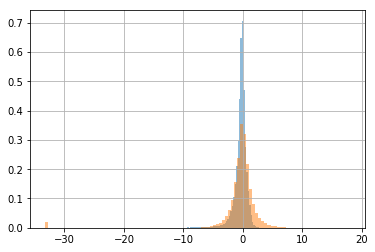

In [12]:
%matplotlib inline
from src.util import sanity_check

sanity_check(train_df["target"], test_df["target"])

In [13]:
test_df[["card_id", "target"]].to_csv("submissions/sub.csv", index=False)

In [14]:
!zip submission.zip submissions/sub.csv

updating: submissions/sub.csv (deflated 52%)
